## Cell2FireML examples (Real landscape -- US)

In [ ]:
# Import
import os
import time
import glob 
import shutil
import signal
import subprocess
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rasterio 

# Basic metrics
from numpy import linalg as LA
from sklearn.metrics import f1_score
from skimage.metrics import structural_similarity as ssim

# Needed to generate Data.csv for Cell2Fire
import utils.DataGeneratorC2 as DataGenerator

### Utils

In [2]:
# Print solutions from results folders
def print_grids_results_folders(folders):
    # Sort
    folders.sort()
    
    # Load and print
    for f in folders:
        grids = glob.glob(os.path.join(f, 'Grids', 'Grids1', '*.csv'))
        file = grids[0]

        # grid = np.loadtxt(file, delimiter=' ')
        grid = np.loadtxt(file, delimiter=',')

        # Plot
        plt.figure(1, figsize=(6,6)) 
        plt.imshow(grid)
        plt.title(f.split(os.path.sep)[-1])
        plt.show()
        time.sleep(0.1)
    
    # Return grid
    return grid
        
# Print solutions from Farsite
def print_grids_farsite_folders(folders, filename='', delimiter=' '):
    # Sort
    folders.sort()
    
    # Load and print
    for f in folders:
        grids = glob.glob(os.path.join(f, filename))
        file = grids[0]

        # Space delimiters
        grid = rasterio.open(file)
        grid = grid.read()
        grid = grid[0, :, :]
        
        grid[grid > 0] = 1
        grid[grid == -9999] = 0
        grid = grid.astype(int)

        # Plot
        plt.figure(1, figsize=(6,6)) 
        plt.imshow(grid, cmap='Reds')
        plt.title(f.split(os.path.sep)[-1])
        plt.show()
        time.sleep(0.1)
    
    # Return grid
    return grid

### Execute Cell2Fire

In [3]:
# Turns a dictionary into a class
class Dict2Class(object):
    def __init__(self, my_dict):
        for key in my_dict:
            setattr(self, key, my_dict[key])

# Pre-processing: Generate the Data.csv file for the C++ core
def generateDataC(args):
    dataName = os.path.join(args.InFolder, "Data.csv")
    if os.path.isfile(dataName) is False:
        print("Generating Data.csv File...")
        DataGenerator.GenDataFile(args.InFolder)    
                    
# Run C++ Sim 
def run(cell2fire_path, args, verbose=False):
    # Parse args for calling C++ via subprocess        
    # old: execArray=[os.path.join(os.getcwd(),'Cell2FireC/Cell2Fire'), 
    execArray=[os.path.join(cell2fire_path,'Cell2Fire'), 
               '--input-instance-folder', args.InFolder,
               '--output-folder', args.OutFolder if (args.OutFolder is not None) else '',
               '--ignitions' if (args.ignitions) else '',
               '--sim-years', str(args.sim_years),
               '--nsims', str(args.nsims),
               '--grids' if (args.grids) else '', 
               '--final-grid' if (args.finalGrid) else '',
               '--Fire-Period-Length', str(args.input_PeriodLen),
               '--output-messages' if (args.OutMessages) else '',
               '--weather', args.WeatherOpt,
               '--nweathers', str(args.nweathers),
               '--ROS-CV', str(args.ROS_CV),
               '--IgnitionRad', str(args.IgRadius), 
               '--seed', str(int(args.seed)),
               '--nthreads', str(int(args.nthreads)),
               '--ROS-Threshold', str(args.ROS_Threshold),
               '--HFI-Threshold', str(args.HFI_Threshold),
               '--HFactor', str(args.HFactor),
               '--BFactor', str(args.BFactor),
               '--FFactor', str(args.FFactor),
               '--EFactor', str(args.EFactor),
               '--bbo' if (args.BBO) else '',
               '--HarvestPlan', args.HCells if(args.HCells is not None) else '',
               '--EllipticalOption', str(args.EllipticalOption),
               '--LBFormula', str(args.LBFormula),
               '--kopt' if (args.KOPT) else '',
               '--verbose' if (args.verbose) else '',]

    # Print exec array
    if verbose:
        print('ExecArray:', ' '.join(execArray))
    
    # Output log
    if args.OutFolder is not None:
        if os.path.isdir(args.OutFolder) is False:
            os.makedirs(args.OutFolder)
        LogName = os.path.join(args.OutFolder, "LogFile.txt")
    else:
        LogName = os.path.join(args.InFolder, "LogFile.txt")   

    # Perform the call
    with open(LogName, 'w') as output:
        proc = subprocess.Popen(execArray, stdout=output)
        proc.communicate()
    return_code = proc.wait()
    if (return_code != 0):
        raise RuntimeError(f'C++ returned {return_code}.\nTry looking at {LogName}.') 

    # End of the replications
    print("End of Cell2FireC execution...")

In [4]:
# Globals
cell2fire_ml_usa = {}
farsite_usa = {}

In [5]:
# Cell2Fire binary
BASE_PATH = '/home/minho/research/fire/c2f_codes/'
CELL2FIRE_PATH = os.path.join(BASE_PATH, 'Cell2FireC_US/')
FARSITE_PATH = os.path.join(BASE_PATH, 'notebooks/farsite')

# Input instance
INSTANCE_PATH = os.path.join(BASE_PATH, 'data_cell2fireML/')
instance_name = 'sherpa_v2' # Default

# Results folder
OUT_PATH = os.path.join(BASE_PATH, 'results_paper_us/')

# Cell2Fire options
args = {
    'InFolder': INSTANCE_PATH + instance_name + '/',
    'OutFolder': OUT_PATH + instance_name + '/',
    'ignitions': True,
    'sim_years': 1,
    'nsims': 1,
    'grids': False, 
    'finalGrid': True,
    'input_PeriodLen': 1.0,
    'OutMessages': False,
    'WeatherOpt': 'rows',
    'nweathers': 1,
    'ROS_CV': 0.0,
    'IgRadius': 0, 
    'seed': 123,
    'ROS_Threshold':0.0,
    'HFI_Threshold':0.0,
    'HFactor':1.0,
    'BFactor':1.0,
    'FFactor':1.0,
    'EFactor':1.0,
    'nthreads':1,
    'BBO': False,
    'HCells': None,
    'verbose': False,
    'EllipticalOption':1, 
    'LBFormula':0, 
    'KOPT':False,
}

# Convert to object
args_obj = Dict2Class(args)

### Sherpa

ExecArray: /home/minho/research/fire/c2f_codes/Cell2FireC_US/Cell2Fire --input-instance-folder /home/minho/research/fire/c2f_codes/data_cell2fireML/sherpa_1H/ --output-folder /home/minho/research/fire/c2f_codes/notebooks/results_paper_us/sherpa_1H/ --ignitions --sim-years 1 --nsims 1  --final-grid --Fire-Period-Length 2.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 1.0 --BFactor 1.0 --FFactor 1.0 --EFactor 0.45  --HarvestPlan  --EllipticalOption 1 --LBFormula 0  
End of Cell2FireC execution...
Execution time: 0.43720245361328125 seconds
Cell2FireML


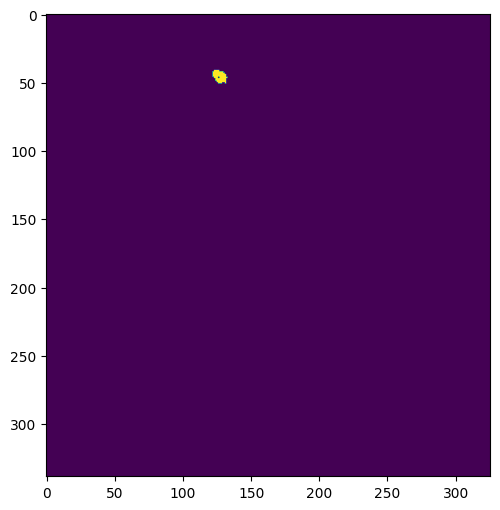

Farsite


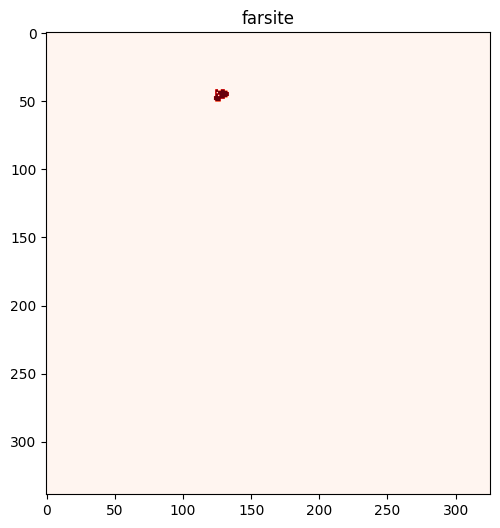

ExecArray: /home/minho/research/fire/c2f_codes/Cell2FireC_US/Cell2Fire --input-instance-folder /home/minho/research/fire/c2f_codes/data_cell2fireML/sherpa_2H/ --output-folder /home/minho/research/fire/c2f_codes/notebooks/results_paper_us/sherpa_2H/ --ignitions --sim-years 1 --nsims 1  --final-grid --Fire-Period-Length 2.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 1.0 --BFactor 1.0 --FFactor 1.0 --EFactor 0.45  --HarvestPlan  --EllipticalOption 1 --LBFormula 0  
End of Cell2FireC execution...
Execution time: 0.4415302276611328 seconds
Cell2FireML


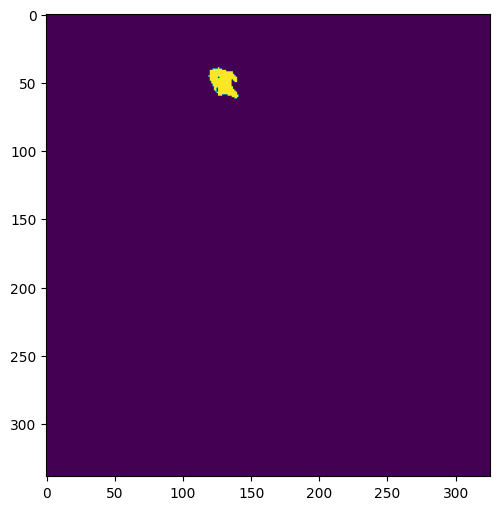

Farsite


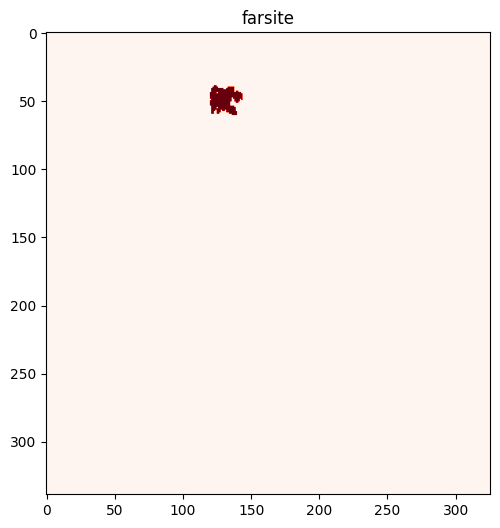

ExecArray: /home/minho/research/fire/c2f_codes/Cell2FireC_US/Cell2Fire --input-instance-folder /home/minho/research/fire/c2f_codes/data_cell2fireML/sherpa_3H/ --output-folder /home/minho/research/fire/c2f_codes/notebooks/results_paper_us/sherpa_3H/ --ignitions --sim-years 1 --nsims 1  --final-grid --Fire-Period-Length 2.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 1.0 --BFactor 1.0 --FFactor 1.0 --EFactor 0.45  --HarvestPlan  --EllipticalOption 1 --LBFormula 0  
End of Cell2FireC execution...
Execution time: 0.45653295516967773 seconds
Cell2FireML


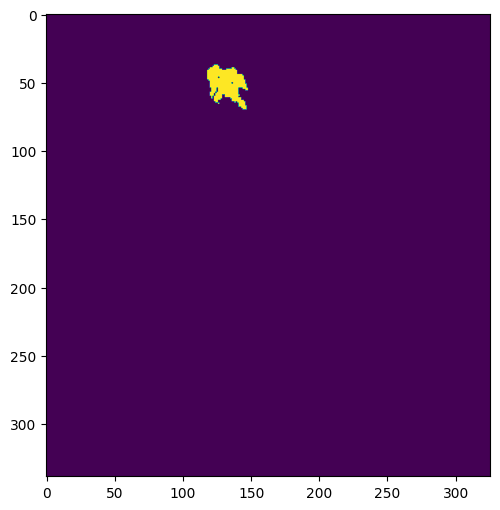

Farsite


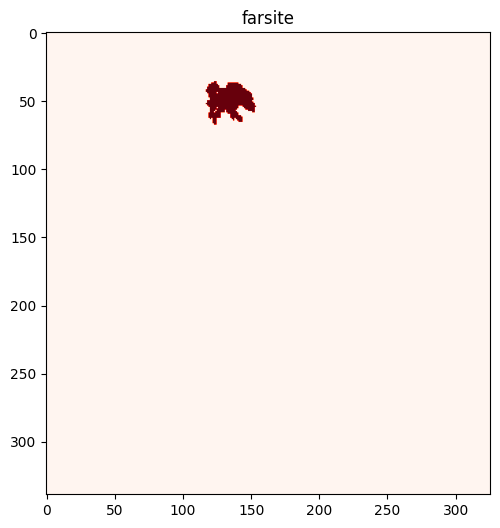

ExecArray: /home/minho/research/fire/c2f_codes/Cell2FireC_US/Cell2Fire --input-instance-folder /home/minho/research/fire/c2f_codes/data_cell2fireML/sherpa_4H/ --output-folder /home/minho/research/fire/c2f_codes/notebooks/results_paper_us/sherpa_4H/ --ignitions --sim-years 1 --nsims 1  --final-grid --Fire-Period-Length 2.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 1.0 --BFactor 1.0 --FFactor 1.0 --EFactor 0.45  --HarvestPlan  --EllipticalOption 1 --LBFormula 0  
End of Cell2FireC execution...
Execution time: 0.5155000686645508 seconds
Cell2FireML


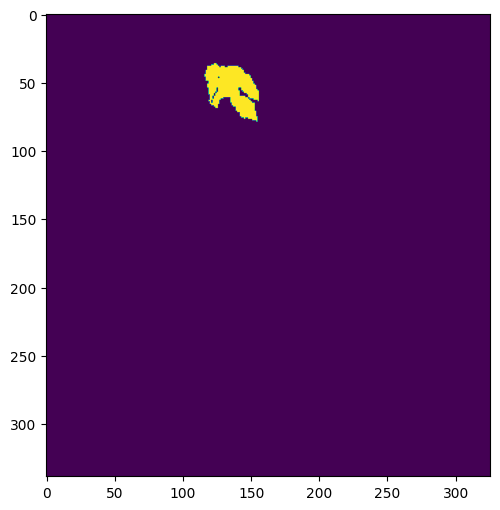

Farsite


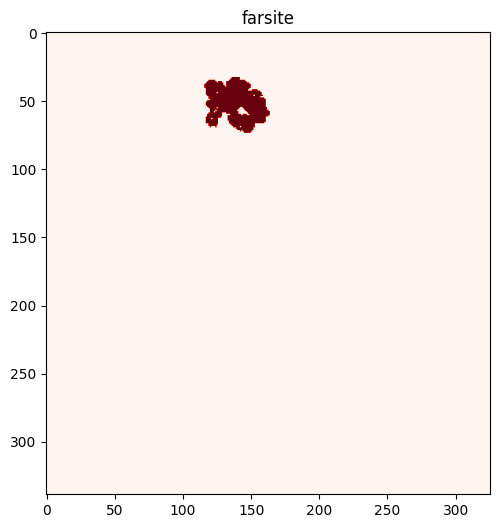

ExecArray: /home/minho/research/fire/c2f_codes/Cell2FireC_US/Cell2Fire --input-instance-folder /home/minho/research/fire/c2f_codes/data_cell2fireML/sherpa_5H/ --output-folder /home/minho/research/fire/c2f_codes/notebooks/results_paper_us/sherpa_5H/ --ignitions --sim-years 1 --nsims 1  --final-grid --Fire-Period-Length 2.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 1.0 --BFactor 1.0 --FFactor 1.0 --EFactor 0.45  --HarvestPlan  --EllipticalOption 1 --LBFormula 0  
End of Cell2FireC execution...
Execution time: 0.5400753021240234 seconds
Cell2FireML


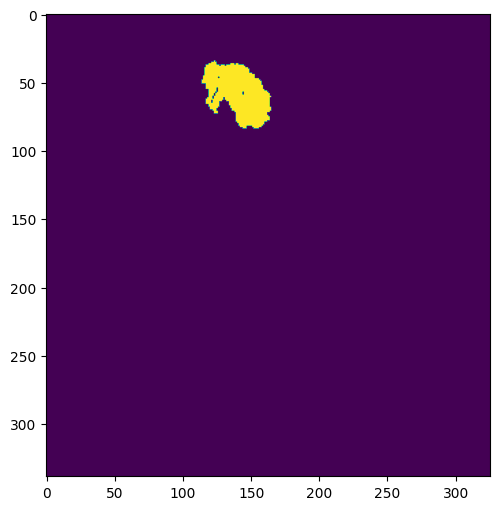

Farsite


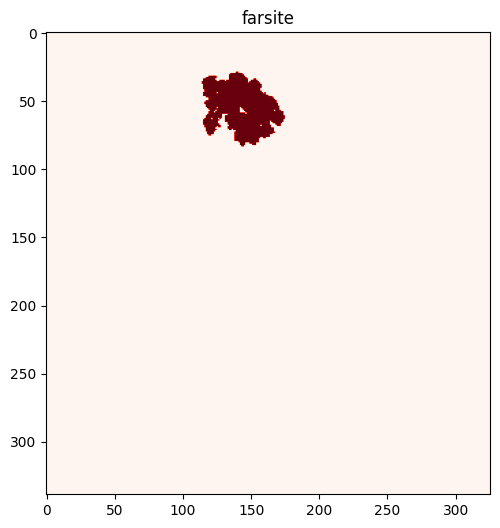

ExecArray: /home/minho/research/fire/c2f_codes/Cell2FireC_US/Cell2Fire --input-instance-folder /home/minho/research/fire/c2f_codes/data_cell2fireML/sherpa_6H/ --output-folder /home/minho/research/fire/c2f_codes/notebooks/results_paper_us/sherpa_6H/ --ignitions --sim-years 1 --nsims 1  --final-grid --Fire-Period-Length 2.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 1.0 --BFactor 1.0 --FFactor 1.0 --EFactor 0.45  --HarvestPlan  --EllipticalOption 1 --LBFormula 0  
End of Cell2FireC execution...
Execution time: 0.5983054637908936 seconds
Cell2FireML


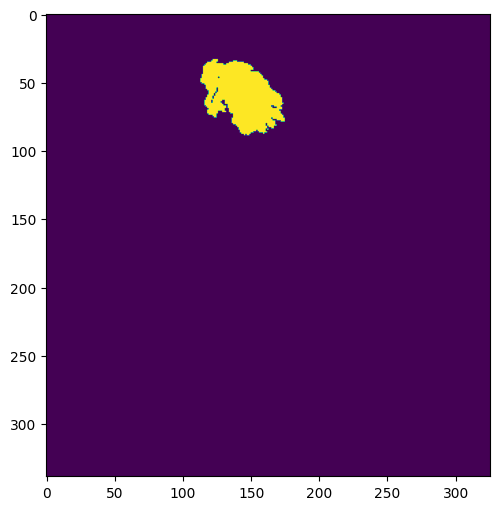

Farsite


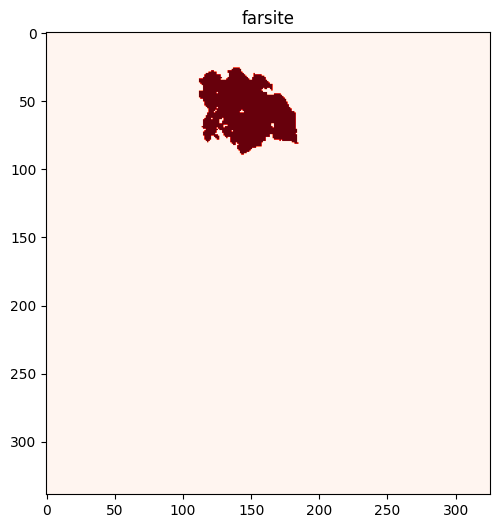

ExecArray: /home/minho/research/fire/c2f_codes/Cell2FireC_US/Cell2Fire --input-instance-folder /home/minho/research/fire/c2f_codes/data_cell2fireML/sherpa_7H/ --output-folder /home/minho/research/fire/c2f_codes/notebooks/results_paper_us/sherpa_7H/ --ignitions --sim-years 1 --nsims 1  --final-grid --Fire-Period-Length 2.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 1.0 --BFactor 1.0 --FFactor 1.0 --EFactor 0.45  --HarvestPlan  --EllipticalOption 1 --LBFormula 0  
End of Cell2FireC execution...
Execution time: 0.6976487636566162 seconds
Cell2FireML


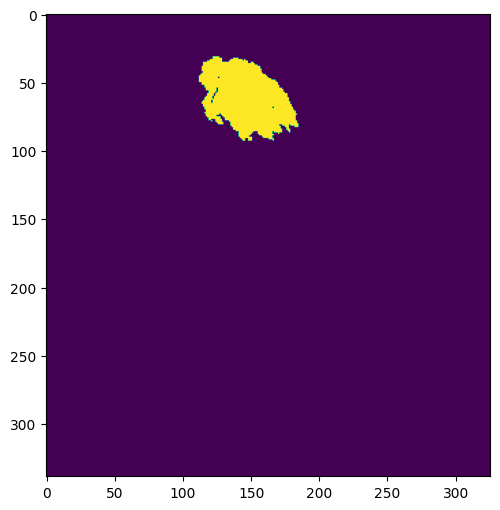

Farsite


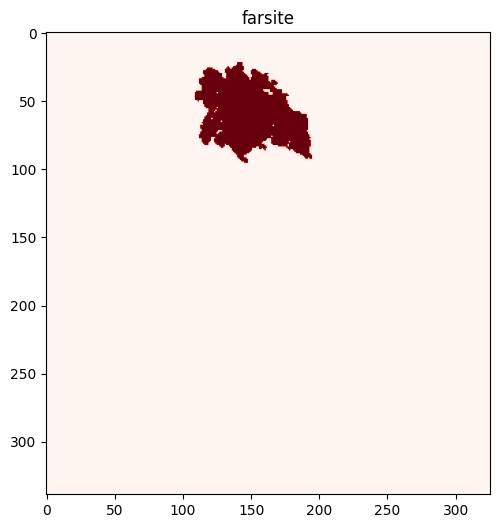

ExecArray: /home/minho/research/fire/c2f_codes/Cell2FireC_US/Cell2Fire --input-instance-folder /home/minho/research/fire/c2f_codes/data_cell2fireML/sherpa_8H/ --output-folder /home/minho/research/fire/c2f_codes/notebooks/results_paper_us/sherpa_8H/ --ignitions --sim-years 1 --nsims 1  --final-grid --Fire-Period-Length 2.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 1.0 --BFactor 1.0 --FFactor 1.0 --EFactor 0.45  --HarvestPlan  --EllipticalOption 1 --LBFormula 0  
End of Cell2FireC execution...
Execution time: 0.736114501953125 seconds
Cell2FireML


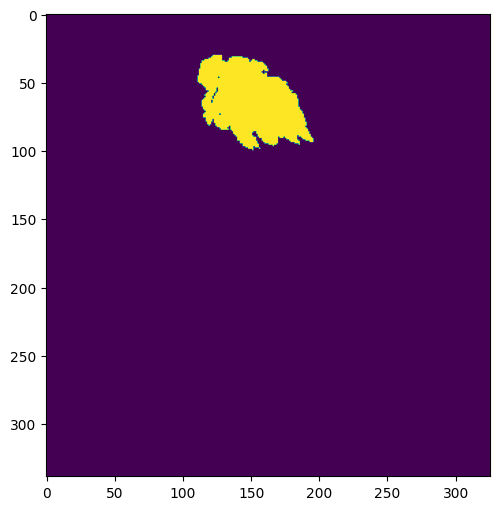

Farsite


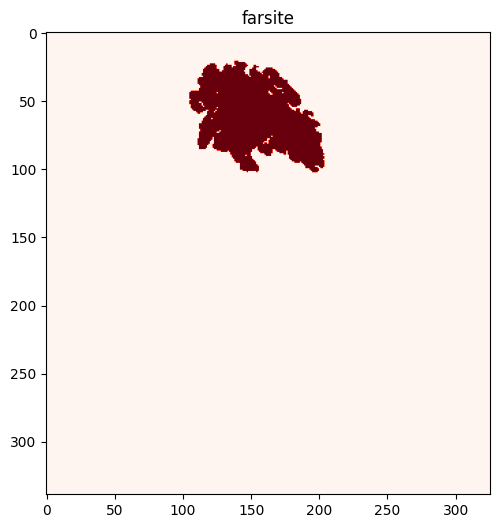

ExecArray: /home/minho/research/fire/c2f_codes/Cell2FireC_US/Cell2Fire --input-instance-folder /home/minho/research/fire/c2f_codes/data_cell2fireML/sherpa_9H/ --output-folder /home/minho/research/fire/c2f_codes/notebooks/results_paper_us/sherpa_9H/ --ignitions --sim-years 1 --nsims 1  --final-grid --Fire-Period-Length 2.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 1.0 --BFactor 1.0 --FFactor 1.0 --EFactor 0.45  --HarvestPlan  --EllipticalOption 1 --LBFormula 0  
End of Cell2FireC execution...
Execution time: 0.8325831890106201 seconds
Cell2FireML


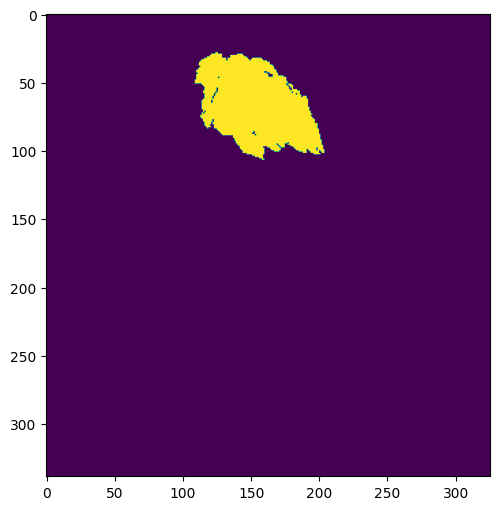

Farsite


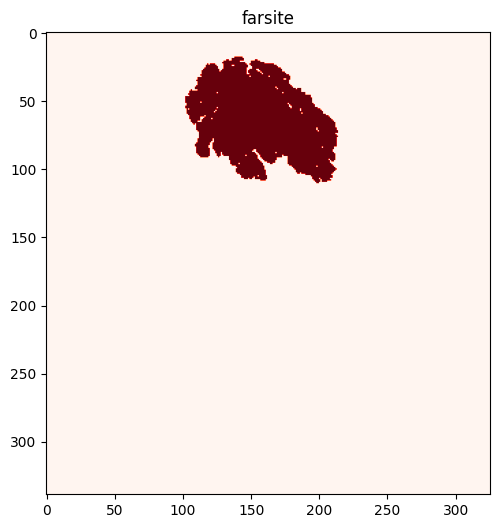

ExecArray: /home/minho/research/fire/c2f_codes/Cell2FireC_US/Cell2Fire --input-instance-folder /home/minho/research/fire/c2f_codes/data_cell2fireML/sherpa_10H/ --output-folder /home/minho/research/fire/c2f_codes/notebooks/results_paper_us/sherpa_10H/ --ignitions --sim-years 1 --nsims 1  --final-grid --Fire-Period-Length 2.0  --weather rows --nweathers 1 --ROS-CV 0.0 --IgnitionRad 0 --seed 123 --nthreads 1 --ROS-Threshold 0.0 --HFI-Threshold 0.0 --HFactor 1.0 --BFactor 1.0 --FFactor 1.0 --EFactor 0.45  --HarvestPlan  --EllipticalOption 1 --LBFormula 0  
End of Cell2FireC execution...
Execution time: 0.9539389610290527 seconds
Cell2FireML


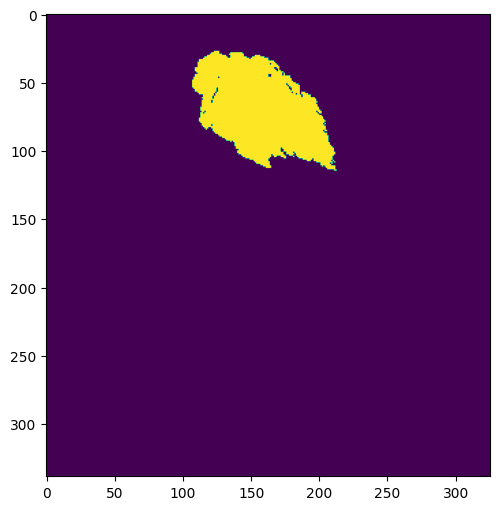

Farsite


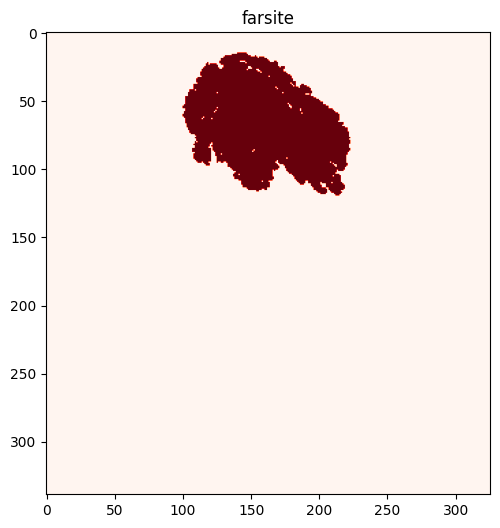

In [13]:
runtimes = []

for hour in range(1, 11):

    # Set new instance
    instance_name = f'sherpa_{hour}H'
    args['InFolder'] = INSTANCE_PATH + instance_name + '/'
    args['OutFolder'] = OUT_PATH + instance_name + '/'

    # Update parameters
    args['input_PeriodLen'] = 2.
    args['HFactor'] = 1.
    args['FFactor'] = 1.
    args['BFactor'] = 1.
    args['EFactor'] = 0.45
    args['EllipticalOption'] = 1
    args['LBFormula'] = 0 

    # Generate data if needed
    generateDataC(args_obj)
    args_obj = Dict2Class(args)
                
    # Execution
    start_time = time.time()
    run(cell2fire_path=CELL2FIRE_PATH, args=args_obj, verbose=True)
    end_time = time.time()
    execution_time = end_time - start_time
    print(f"Execution time: {execution_time} seconds")

    # Outputs
    print('Cell2FireML')
    cell2fire_ml_usa[instance_name] = print_grids_results_folders([args_obj.OutFolder])

    print('Farsite')
    try:
        farsite_usa[instance_name] = print_grids_farsite_folders(folders=[FARSITE_PATH], filename=instance_name + '.tif', delimiter=' ')
    except:
        print('No ground truth')

    runtimes.append(execution_time)

In [14]:
# Loop through each instance and record results
sherpa_outputs_cell2fireml = {}
sherpa_outputs_farsite = {}
df_results_all = {}

# Loop 
for k in cell2fire_ml_usa.keys():
    if 'sherpa' in k:
        # Metrics
        cell2fire = cell2fire_ml_usa[k]
        farsite = farsite_usa[k]
        # cell2fire[cell2fire == 0] = np.nan
        # farsite[farsite == 0] = np.nan

        norm = LA.norm(cell2fire - farsite)
        mse = ((cell2fire - farsite)**2).mean()
        f1 = f1_score(farsite.flatten() , cell2fire.flatten(), average='macro')
        ssim_sc = ssim(cell2fire, farsite, data_range=1)
        area_cell2fire = len(cell2fire[cell2fire == 1])
        area_farsite = len(farsite[farsite == 1])

        # Results
        df_results = pd.DataFrame({'Instance':[k],
                                  '$\delta$ norm':[norm],
                                  'MSE': [mse],
                                  'F1': [f1],
                                  'SSIM': [ssim_sc],
                                  'AreaCell2FireML': [area_cell2fire],
                                  'AreaFarsite': [area_farsite],
                                  }).round(3)
        df_results_all[k] = df_results

<>:24: SyntaxWarning: invalid escape sequence '\d'
<>:24: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_1240593/690256421.py:24: SyntaxWarning: invalid escape sequence '\d'
  '$\delta$ norm':[norm],


In [15]:
df_results_all = pd.concat([_ for _ in df_results_all.values()], axis=0).reset_index(drop=True)
df_results_all['cell2fireml_runtime'] = runtimes
df_results_all

,Instance,$\delta$ norm,MSE,F1,SSIM,AreaCell2FireML,AreaFarsite,cell2fireml_runtime
0,sherpa_1H,6.164,0.000,0.870,0.998,77,69,0.437202
1,sherpa_2H,10.296,0.001,0.921,0.996,312,360,0.441530
2,sherpa_3H,15.716,0.002,0.904,0.991,576,717,0.456533
3,sherpa_4H,21.633,0.004,0.898,0.986,1012,1300,0.515500
4,sherpa_5H,25.515,0.006,0.911,0.981,1608,2099,0.540075
5,sherpa_6H,31.718,0.009,0.901,0.975,2200,2994,0.598305
6,sherpa_7H,35.539,0.011,0.904,0.969,2932,3869,0.697649
7,sherpa_8H,42.059,0.016,0.898,0.959,3774,5231,0.736115
8,sherpa_9H,48.713,0.021,0.892,0.951,4724,6871,0.832583
9,sherpa_10H,53.628,0.026,0.893,0.943,5804,8546,0.953939


In [16]:
# Farsite runtimes from manual experiments
fariste_runtimes = [0.04, 0.03, 0.05, 0.1, 0.18, 0.32, 0.59, 0.84, 1.21, 1.73]
df_results_all['farsite_runtime'] = fariste_runtimes
df_results_all

,Instance,$\delta$ norm,MSE,F1,SSIM,AreaCell2FireML,AreaFarsite,cell2fireml_runtime,farsite_runtime
0,sherpa_1H,6.164,0.000,0.870,0.998,77,69,0.437202,0.04
1,sherpa_2H,10.296,0.001,0.921,0.996,312,360,0.441530,0.03
2,sherpa_3H,15.716,0.002,0.904,0.991,576,717,0.456533,0.05
3,sherpa_4H,21.633,0.004,0.898,0.986,1012,1300,0.515500,0.10
4,sherpa_5H,25.515,0.006,0.911,0.981,1608,2099,0.540075,0.18
5,sherpa_6H,31.718,0.009,0.901,0.975,2200,2994,0.598305,0.32
6,sherpa_7H,35.539,0.011,0.904,0.969,2932,3869,0.697649,0.59
7,sherpa_8H,42.059,0.016,0.898,0.959,3774,5231,0.736115,0.84
8,sherpa_9H,48.713,0.021,0.892,0.951,4724,6871,0.832583,1.21
9,sherpa_10H,53.628,0.026,0.893,0.943,5804,8546,0.953939,1.73


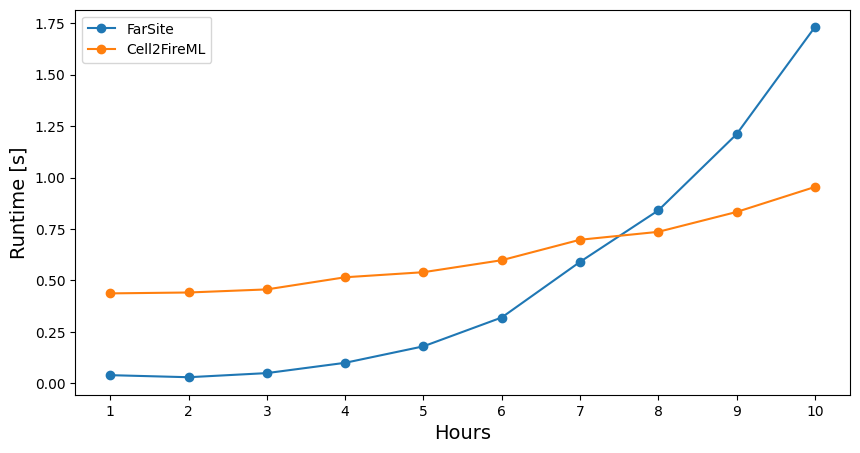

In [17]:
# Plot runtime
fig, ax = plt.subplots(1, figsize=(10,5))

ax.plot(df_results_all['farsite_runtime'], marker='o', label='FarSite')
ax.plot(df_results_all['cell2fireml_runtime'], marker='o', label='Cell2FireML')

ax.set_xticks(np.arange(0, 10, 1))
ax.set_xticklabels(np.arange(1, 11, 1))
ax.set_xlabel("Hours", size=14)
ax.set_ylabel('Runtime [s]', size=14)

plt.legend(loc='best')
plt.show()